In [2]:
# !pip install rasterio

# Reading satellite data rasterio

In [1]:
import rasterio as rio
from rasterio import plot
import fiona
import rasterio.mask
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import georaster
import geopandas as gpd
import glob
import numpy as np
from osgeo import gdal
import scipy.misc as sm
from PIL import Image
from osgeo import gdal
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Open the image as NDVI created before and saved in local machine
NDVI = rio.open('C:/Users/Jeannette/Desktop/ISHANGO-AIMS/S2B_MSIL2A_20190226T074859_N0211_R135_T36LWL_20190226T135056.SAFE/GRANULE/L2A_T36LWL_A010314_20190226T081205/IMG_DATA/R10m/NDVISs.tif')
print(NDVI.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32736), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 8600020.0)}


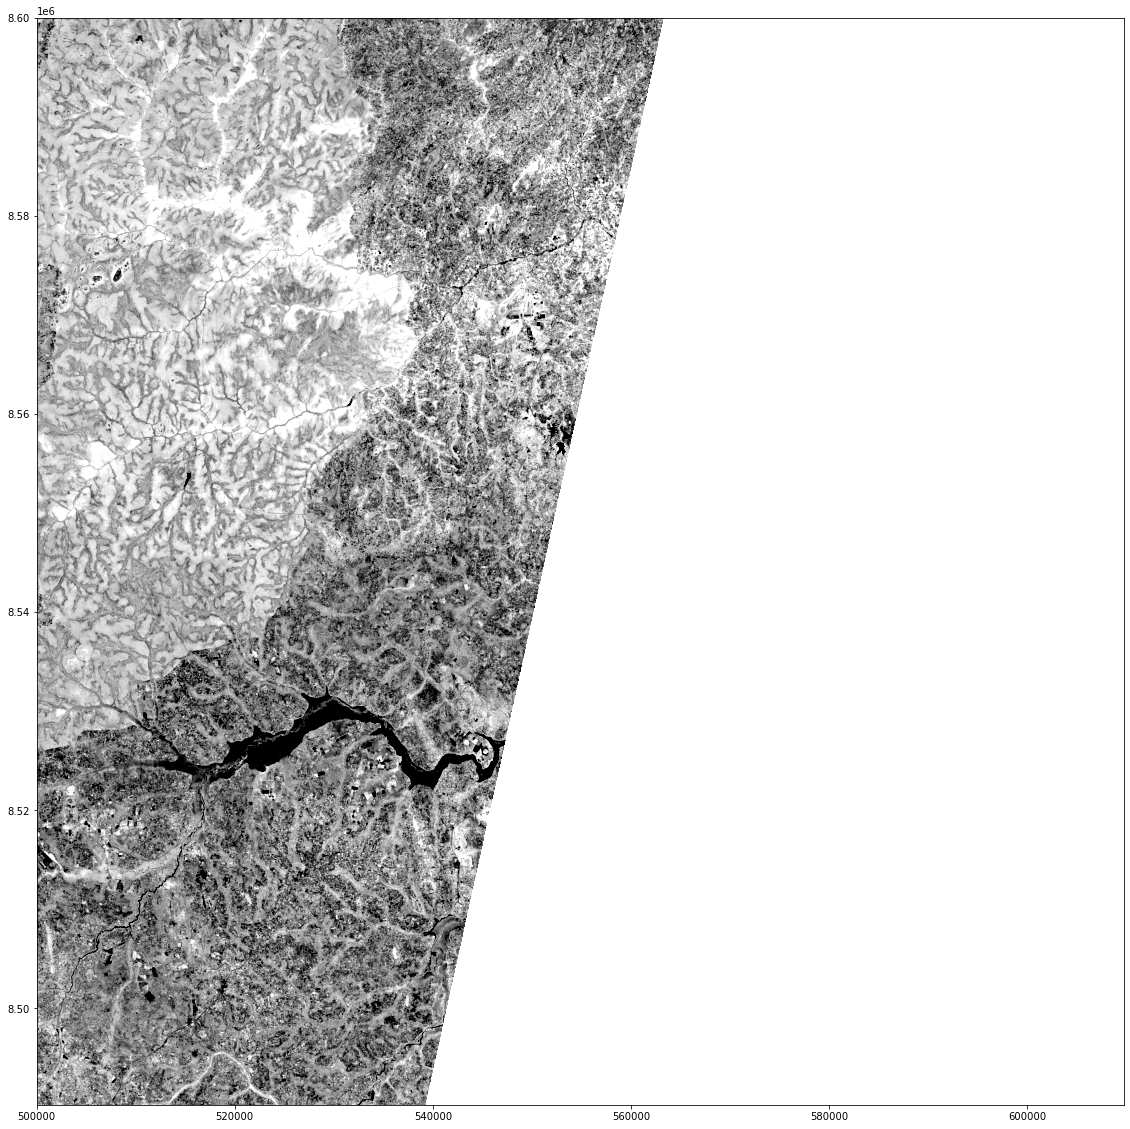

In [54]:
# Read, enhance and show the image
NDVI_arr = NDVI.read() # read the opened image
vmin, vmax = np.nanpercentile(NDVI_arr, (5,95))  # 5-95% contrast stretch
# show the enhanced image
plt.figure(figsize=[20,20])
show(NDVI, cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

In [93]:
# create an empty array with same dimension and data type
imgxyb = np.empty((NDVI.height, NDVI.width, NDVI.count), NDVI.meta['dtype'])
# loop through the raster's bands to fill the empty array
for band in range(imgxyb.shape[2]):
    imgxyb[:,:,band] = NDVI.read(band+1)

In [94]:
print(imgxyb.shape)

(10980, 10980, 1)


In [95]:
# convert to 1d array
img1d=imgxyb[:,:,:3].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))

In [96]:
img1d.shape

(120560400, 1)

In [97]:
print(np.isnan(img1d))

[[False]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [ True]]


In [103]:
img1d[np.isnan(img1d)] = 0
img1d.shape
print(np.isnan(img1d))

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


# Training/ KMeans classification

Training the model with  the n_clusters as parameter which represents the number of clusters that we want to group our pixels into. there are 3 classes and additional 1 class which is outside of ROI

In [113]:
cl = cluster.KMeans(n_clusters=4) # Kmeans classifier
param = cl.fit(img1d) # train model
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(imgxyb[:,:,0].shape) # reshape labels to a 3d array (one band only)

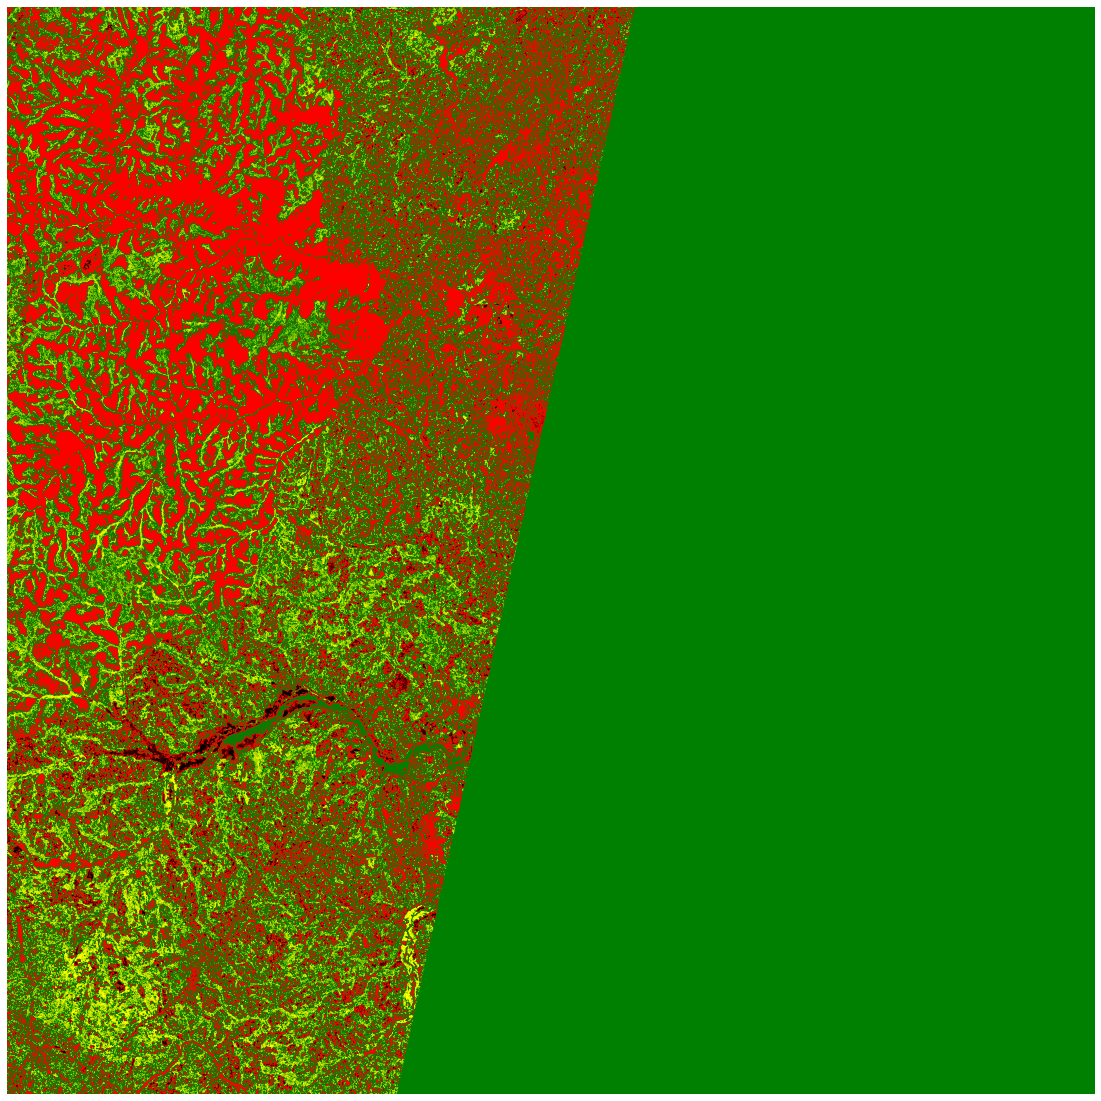

In [114]:
# Create a custom color map to represent our different 4 classes
cmap = mc.LinearSegmentedColormap.from_list("", ["black","red","green","yellow"])
# Show the resulting array and save it as jpg image
plt.figure(figsize=[20,20])
plt.imshow(img_cl, cmap=cmap)
plt.axis('off')
plt.savefig("elhas_clustered.jpg", bbox_inches='tight')
plt.show()

Somethin went wrong! because the outside part of ROI has been clustered which is not correct,i am still finding how to correct so that this green part are not supposed to be part of clusters.
The clusters are not well classied. and are not defined

# Prediction

Once the classifier is trained, it can be used to predict the same learned clusters in any unseen image saved locally, is also NDVI image

In [116]:
# open the raster image
image = rio.open('C:/Users/Jeannette/Downloads/NDVI.tif')
# create an empty array with same dimensions and data type 
image_xyb = np.empty((image.height, imagel.width,image.count), image.meta['dtype'])
# loop through the raster bands and fill the empty array in x-y-bands order
for band in range(image_xyb.shape[2]):
    image_xyb[:,:,band] = image.read(band+1)
# convert to 1d array
image_1d = image_xyb[:,:,:3].reshape(image_xyb.shape[0]*image_xyb.shape[1], image_xyb.shape[2])
image_1d[np.isnan(image_1d)] = 0
# predict the clusters in the image 
pred = cl.predict(image_1d)
# reshape the 1d array predictions to x-y-bands shape order (only one band)
image_cul = pred
image_cul = image_cul.reshape(image_xyb[:,:,0].shape)

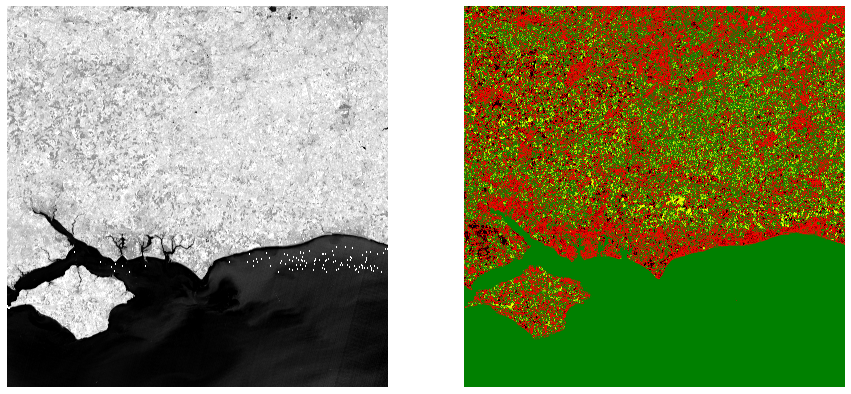

In [117]:
image_arr = imagel.read() # Read the image
vmin, vmax = np.nanpercentile(image_arr, (5,95)) # 5–95% contrast stretch
# show the original and predicted image
fig, (ax1,ax2) = plt.subplots(figsize=[15,15], nrows=1,ncols=2, sharey=False,)
show(imagel, cmap='gray', vmin=vmin, vmax=vmax, ax=ax1)
show(image_cul, cmap=cmap, ax=ax2)
ax1.set_axis_off()
ax2.set_axis_off()
fig.savefig("pred.png", bbox_inches='tight')
plt.show()

The left image is truth image and the right image is predicted one.
Also the cluster are not classified well.